In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd, numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import plotnine as pn

import mtg
from importlib import reload
reload(mtg);

In [4]:
past_games = mtg.PastGames()

## Training a surrogate over the historical games.

/home/mson/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
/home/mson/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: l2_lambda
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[1]	training's binary_logloss: 0.69112	valid_1's binary_logloss: 0.691237
[2]	training's binary_logloss: 0.689133	valid_1's binary_logloss: 0.689382
[3]	training's binary_logloss: 0.68758	valid_1's binary_logloss: 0.687934
[4]	training's binary_logloss: 0.685945	valid_1's binary_logloss: 0.686393
[5]	training's binary_logloss: 0.684617	valid_1's binary_logloss: 0.685127
[6]	training's binary_logloss: 0.683202	valid_1's binary_logloss: 0.683828
[7]	training's binary_logloss: 0.681925	valid_1's binary_logloss: 0.682696
[8]	training's binary_logloss: 0.680616	valid_1's binary_logloss: 0.681515
[9]	training's binary_logloss: 0.679682	valid_1's binary_logloss: 0.680606
[10]	training's binary_logloss: 0.678736	valid_1's binary_logloss: 0.67972
[11]	training's binary_logloss: 0.677762	valid_1's binary_logloss: 0.678804
[12]

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

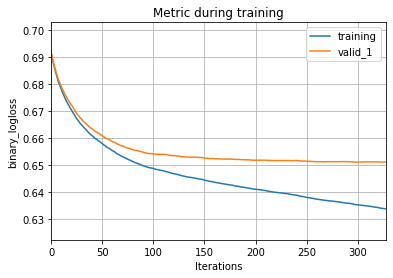

In [5]:
lgb_params = {'objective': 'binary', 'num_leaves': 32, 'l2_lambda': 0.3, 'max_depth': -1}

model = lgb.LGBMClassifier(**lgb_params, num_boost_round=1000)
trn, val = past_games.dsets.sets['trn'], past_games.dsets.sets['val']
model.fit(**past_games.dsets.sets['trn'], eval_set=[(trn['X'], trn['y']), (val['X'], val['y'])],
          early_stopping_rounds=30)
pos_idx = np.argmax(model.classes_)
lgb.plot_metric(model)

## Evaluating the surrogate.

In [6]:
y = past_games.dsets.sets['tst']['y']
pred = model.predict_proba(past_games.dsets.sets['tst']['X'])[:, pos_idx]
roc_auc_score(y_true=y, y_score=pred)

0.6574472008773319

##### Calibrated?

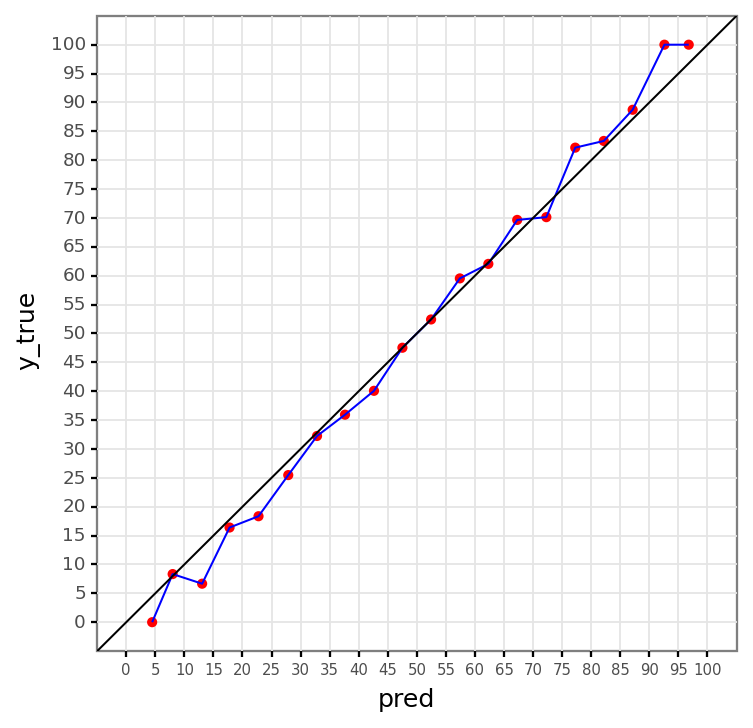

<ggplot: (8776086071769)>

In [7]:
pn.options.dpi = 165
mtg.CalibrationAnalyzer(y, pred).plot

### Seeing which of all possible decks the surrogate favors against the rival's.

In [8]:
rival_deck = mtg.RivalDeck(past_games).deck

In [9]:
possibles = mtg.PossibleDecks(past_games)
decks = possibles.get_decks()

In [10]:
deck_defeater = mtg.DeckDefeater(model, decks, rival_deck)
assert (deck_defeater.possible_games.columns == past_games.dsets.sets['trn']['X'].columns).all()
print(f"Mean win probability: {deck_defeater.mean_win_proba:.0%}\n\n")
print(f"Best deck:\n{deck_defeater.best_deck_str}")

Mean win probability: 42%


Best deck:
Alessin_Adamant_Angel_Deck_A_Count: 1
Bold_Battalion_Deck_A_Count: 0
Dreadwing_Darkfire_Dragon_Deck_A_Count: 0
Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count: 7
Gentle_Guard_Deck_A_Count: 0
Horrible_Hooligan_Deck_A_Count: 0
Kindly_Knight_Deck_A_Count: 0
Lilac_Lotus_Deck_A_Count: 3
Murderous_Minotaur_Deck_A_Count: 1
Patchy_Pirate_Deck_A_Count: 0
Sword_of_Shadows_Deck_A_Count: 0
Virtuous_Vigilante_Deck_A_Count: 0

win probability: 69%


In [11]:
deck_defeater.possible_decks_and_predictions

,Alessin_Adamant_Angel_Deck_A_Count,Bold_Battalion_Deck_A_Count,Dreadwing_Darkfire_Dragon_Deck_A_Count,Evil_Emperor_Eschatonus_Empyreal_Envoy_of_Entropic_End_Deck_A_Count,Gentle_Guard_Deck_A_Count,Horrible_Hooligan_Deck_A_Count,Kindly_Knight_Deck_A_Count,Lilac_Lotus_Deck_A_Count,Murderous_Minotaur_Deck_A_Count,Patchy_Pirate_Deck_A_Count,Sword_of_Shadows_Deck_A_Count,Virtuous_Vigilante_Deck_A_Count,p
0,1,0,0,7,0,0,0,3,1,0,0,0,0.693111
1,1,0,0,8,0,0,0,3,0,0,0,0,0.692379
2,3,0,0,5,0,0,0,3,1,0,0,0,0.688500
3,3,0,0,0,0,1,0,0,0,6,2,0,0.681257
4,1,0,1,7,0,0,0,3,0,0,0,0,0.679105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352073,8,0,1,1,0,0,0,0,0,0,2,0,0.021536
1352074,9,0,1,0,0,0,0,0,0,0,2,0,0.021330
1352075,8,0,2,1,0,0,0,0,0,0,1,0,0.021112
1352076,8,0,1,0,0,0,0,0,0,0,3,0,0.020778


## Choosing decks for competitive play.
Strategies; we could choose the best... :
* whole-universe-generalist deck: the deck that performs best against all possible decks.
* actual-universe-generalist deck: the deck that performs best against all decks in the input data.
* whole-universe-counter deck: the deck that performs best against the whole-universe generalist deck.
* actual-universe-counter deck
* And so on, down the levels of recursion.
* Alternatively, the whole-universe-part-generalist-part-counter deck: 
a deck in-between  
the whole-universe-generalist deck 
and the whole-universe-counter deck.
* actual-universe-part-generalist-part-counter deck
* More?

#### Finding the whole-universe-generalist deck.

In [12]:
scorer = mtg.GameScorer(decks, model)

In [13]:
# Need to chunk deck A too. Holy cow!
# Could we code up or use a gradient descent package 
# that helps us search deck-space?
# It would be implemented for every possible Deck A,
# to search a subspace of the possible deck B's.
scored_chunks = scorer.score_chunks(10, 5)
scored_chunks

(10, 12)


In [5]:
import psutil
psutil.virtual_memory().available / 10**9

5.66204416

In [3]:
scored_chunks

NameError: name 'scored_chunks' is not defined

## Analyzing the structure of deck-space.

## Analyzing the structure of matchups-space.